In [20]:
""" Imports """

import numpy as np
import matplotlib.pyplot as plt

from core import (
    Policy,
    Option,
    Subtask,
    RewardRespectingFeatureAttainment,
)
from plot import (
    plot_deterministic_policy,
    plot_heatmap_from_state_scores
)
from agent import SMDPQLearning
from env import (
    TwoRooms,
    FourRooms,
    get_primitive_actions_as_options
)

from trajectory_sampler import sample, reset
from empowerment import compute_empowerment
from option_learning import (
    actor_critic,
    to_deterministic_policy
)

In [2]:
""" Environment setup """

# Start states
tworooms_default_s0 = 24

tworooms_left_room = [
    0, 1, 2, 3, 4, 5,
    12, 13, 14, 15, 16, 17,
    24, 25, 26, 27, 28, 29,
    36, 37, 38, 39, 40, 41,
    48, 49, 50, 51, 52, 53,
    60, 61, 62, 63, 64, 65,
]

fourrooms_default_s0 = 30

fourrooms_first_room = [
    0, 1, 2, 3, 4,
    10, 11, 12, 13, 14,
    20, 21, 22, 23, 24,
    30, 31, 32, 33, 34,
    40, 41, 42, 43, 44,
]

# Create the environment
tworooms = TwoRooms(
    start_state=tworooms_default_s0,
    goal_state=68,
    negative_states_config="none",
    max_steps=None
)

fourrooms = FourRooms(
    start_state=fourrooms_first_room,
    goal_state=75,
    negative_states_config="default",
    max_steps=None,
    sparse_rewards=True
)

env = tworooms

print("Environment:", env.__class__.__name__)

Environment: TwoRooms


In [3]:
""" Agent setup """

# Set up the agent with primitive options (actions)
primitive_options = get_primitive_actions_as_options(env)

agent = SMDPQLearning(
    env,
    primitive_options,
    learning_rate=0.1,
    discount_factor=0.99,
    exploration_rate=0.1,
    min_exploration_rate=0.1,
    exploration_decay=1,
    store_experience=True
)

print("Agent:", agent.__class__.__name__)


Agent: SMDPQLearning


In [4]:
""" Reset """

# Reset the environment and agent
reset(env, agent)

(<env.TwoRooms at 0x24ac84da660>, <agent.SMDPQLearning at 0x24ae616b620>)

In [5]:
""" Simulate first stage of training """

# Number of sampled trajectories in first stage of training
n = 20

print("Sampling trajectories...", end=" ")
trajectories, results, steps = sample(env, agent, n)
print("done.")

Sampling trajectories... 

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 25.07it/s]

done.


In [6]:
# dummy

In [7]:
""" Run the offline procedure to compute empowerment """

# Get experience buffer
eb = agent.eb.copy()
print("Collected experience in buffer", eb.size)

# Build transition matrix
states, actions, next_states = eb.transition_matrix()
assert states.shape == actions.shape == next_states.shape

unique_states = np.unique(states)
unique_actions = np.unique(actions)
unique_next_states = np.unique(next_states)

T = np.zeros((unique_next_states.shape[0], unique_actions.shape[0], unique_states.shape[0]), dtype=np.float64)
for s, a, ns in zip(states, actions, next_states):
    try:
        T[ns, a, s] = 1.
    except IndexError:
        print(f"IndexError for state {s}, action {a}, next_state {ns}.")
        continue

# Check the shape of the transition matrix
print("Build transition matrix T of shape", T.shape)

# Compute empowerment score for each state
emp_scores = {}
for s in range(unique_states.shape[0]):
    emp_scores[s] = compute_empowerment(T, 5, s)
emp_scores

# Select highest empowerment scores
n_selected = 3
empowerment_scores = sorted(emp_scores.items(), key=lambda state_emp: state_emp[1], reverse=True)
selected = [state_emp[0] for state_emp in empowerment_scores[:n_selected]]
print("Selected %d states with highest empowerment scores" % n_selected, selected)

# Define subgoal
subgoal = np.random.choice(selected)
print("Subgoal randomly selected", subgoal)

Collected experience in buffer 3552
IndexError for state 29, action 3, next_state 68.
IndexError for state 68, action 0, next_state 68.
IndexError for state 68, action 3, next_state 30.
IndexError for state 55, action 1, next_state 67.
IndexError for state 67, action 2, next_state 66.
IndexError for state 66, action 3, next_state 67.
IndexError for state 29, action 3, next_state 68.
IndexError for state 68, action 3, next_state 30.
IndexError for state 57, action 1, next_state 69.
IndexError for state 69, action 1, next_state 69.
IndexError for state 69, action 1, next_state 69.
IndexError for state 69, action 1, next_state 69.
IndexError for state 69, action 3, next_state 70.
IndexError for state 70, action 2, next_state 69.
IndexError for state 69, action 1, next_state 69.
IndexError for state 69, action 1, next_state 69.
IndexError for state 69, action 0, next_state 57.
IndexError for state 55, action 1, next_state 67.
IndexError for state 29, action 3, next_state 68.
IndexError for

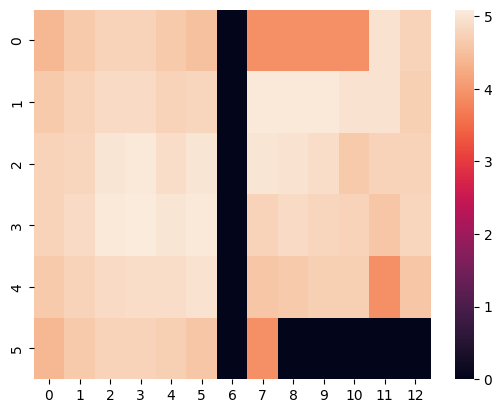

In [8]:
""" Visualize empowerment scores"""

plot_heatmap_from_state_scores(env, emp_scores)


In [ ]:
""" Learn an option to reach the subgoal """

# Create a subtask with the discovered subgoal
subgoal1 = RewardRespectingFeatureAttainment(env, feature_attainment= subgoal)
w, theta = actor_critic(subgoal1, alpha=0.1, gamma=0.99, alpha_=0.1, number_of_steps=50000)
policy1: Policy = to_deterministic_policy(env, theta)


100%|██████████| 50000/50000 [00:03<00:00, 13013.99it/s]


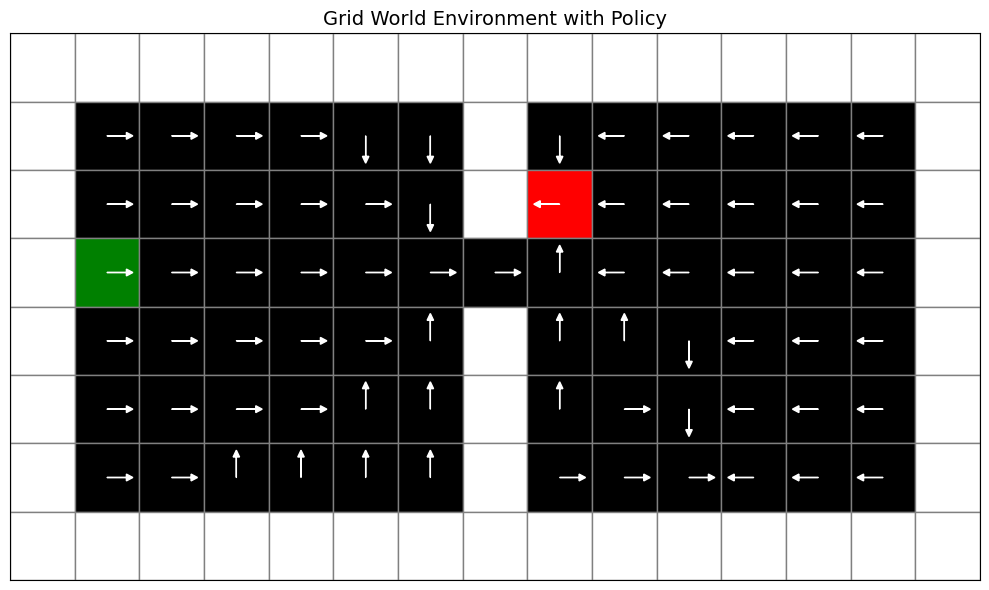

In [12]:
""" Visualize learned option """

plot_deterministic_policy(env, policy1, subgoal1)


In [ ]:
""" Add the option to the agent """

# Define the option
def termination_fn(state):
    """ Termination condition for the option """
    return state == subgoal or state == env.goal_transition_state

option1 = Option(
    id=f"o1_to_subgoal_{subgoal}",
    initiation_set=unique_states,
    policy=policy1,
    termination=termination_fn
)

# Add the option to the agent
agent.add_option(option1)
print("Added option", option1.id, "to agent.")


TypeError: Option.__init__() got an unexpected keyword argument 'termination_condition'

In [15]:
trajectories_before = trajectories.copy()
results_before = results.copy()
steps_before = steps.copy()


In [16]:
""" Simulate second stage of training """

# Number of sampled trajectories in second stage of training
n = 30

print("Sampling trajectories with option...", end=" ")
trajectories, results, steps = sample(env, agent, n)
print("done.")


Sampling trajectories with option... 

100%|██████████| 30/30 [00:00<00:00, 97.45it/s]

done.


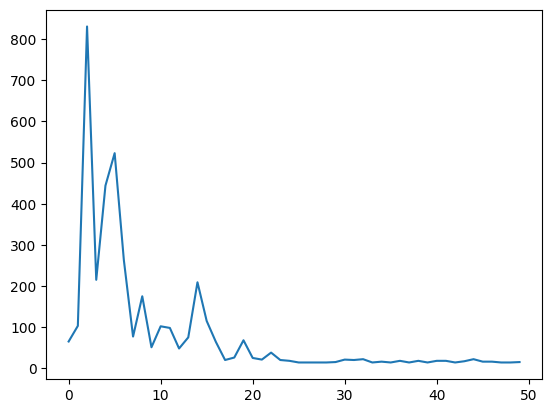

In [21]:
plt.plot(steps_before + steps)